# Import everything:

In [1]:
import simmetis as sm
from astropy import units as u
%pylab inline

Package wget is not available. simmetis.get_extras() will not work.


/Users/koehler/METIS/SimMETIS/simmetis/psf.py:125: UserWarning: Poppy is not installed. Functions beginning with "poppy_"
                  will not work. See http://pythonhosted.org/poppy/
  will not work. See http://pythonhosted.org/poppy/""")


Populating the interactive namespace from numpy and matplotlib


# Load the input and config files to create a simulator instance.
## Adjust the path to point to the file on your system.

In [9]:
lms = sm.spectro.LMS("../../LMSsim/LINE_3D_013.fits", "metis_spectro_LMS.config")

Source file  ../../LMSsim/LINE_3D_013.fits
201 x 201 pixels, 251 spectral channels
image pixscale: [4.01736511 4.01736511] mas per pixel
BUNIT: JY/PIXEL
Pixel area is 1.6139222426878185e-05 arcsec2
CTYPES: ['RA---SIN', 'DEC--SIN', 'FREQ']
Wavelengths: [4.79232483 4.79233122 4.79233761] um ... 4.793923642827597 um
restfrq: 62546358407090.0
restwav: 0.0
Source velocities (WCS): -49991.66226419067 m / s ... 50008.34051741877 m / s
new naxis3: 67
middle v: 8.339126614049746 m / s
Detector velocities: (67,) -49491.66087338595 ... 49508.33912661405
Reading config  metis_spectro_LMS.config
Pixel scale  8.200000000000001  mas/pixel
Filter =  ../data/TC_filter_open.dat


# Compute transmission and emission for "best" conditions:

-----Transmission and Emission-----
Plotting pixel [111,100] from source cube


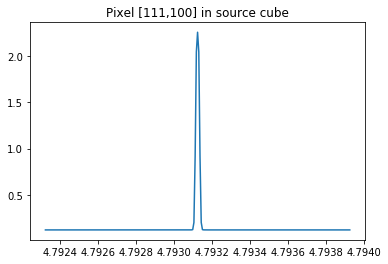

Reading  ../data/skycal_R308296_best_conditions.fits
Index skytran to src-wave: 483105 ... 483207
Plotting sky transmission in source wavelength range...
Steaming up optical train


/Users/koehler/METIS/SimMETIS/simmetis/psf.py:1200: UserWarning: CDELT > 1. Assuming the scale to be [mas]
  warnings.warn("CDELT > 1. Assuming the scale to be [mas]")
/Users/koehler/miniconda3/lib/python3.7/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Plotting SimMetis-transmission in source wavelength range...


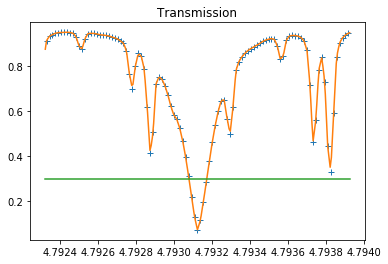

Plotting pixel [111,100] from transmitted cube


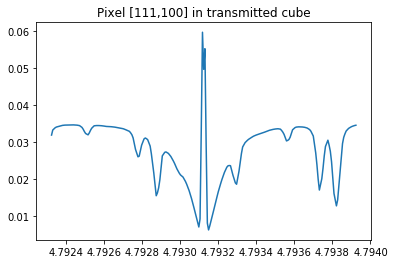

Pix_res:  0.0082
Mirror area:  1037.3460402337157 [m^2]
Plotting atmospheric & mirror emission...


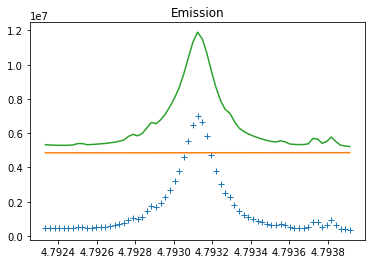

In [10]:
lms.transmission_emission(conditions='best', plot=True)

# Convolve with the PSF.
## Adjust the filename to point to the PSF-file you want to use:

-----Convolution with PSF-----
image pixscale from WCS: [4.01736511 4.01736511] mas / pixel
PSF for 3.8um is extension 2
PSF pixel scale is 7.65457 mas/pix @ 3.8 um, (1024, 1024) pixels
PSF pixel scale is 9.655080079899458 mas/pix @ 4.7931241472242 um,
Scale factor 2.4033364694476194
scale_image: old shape = (1024, 1024)
scale_image: new shape = (2460, 2460)
Normalizing PSF by factor 1115181061089040.1
Cropping PSF to [ 1029 : 1432 , 1029 : 1432 ]
Convolving with PSF...
251 250 249 248 247 246 245 244 243 242 241 240 239 238 237 236 235 234 233 232 231 230 229 228 227 226 225 224 223 222 221 220 219 218 217 216 215 214 213 212 211 210 209 208 207 206 205 204 203 202 201 200 199 198 197 196 195 194 193 192 191 190 189 188 187 186 185 184 183 182 181 180 179 178 177 176 175 174 173 172 171 170 169 168 167 166 165 164 163 162 161 160 159 158 157 156 155 154 153 152 151 150 149 148 147 146 145 144 143 142 141 140 139 138 137 136 135 134 133 132 131 130 129 128 127 126 125 124 123 122 121 1

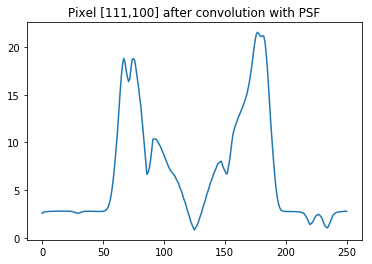

In [11]:
lms.convolve_psf("../../LMSsim/metis_psf_mag=08.00_seeing=1.00.fits", plot=True)

# Convolve with the LSF:

-----Convolution with LSF-----
step in wavelen: 6.395256595485677e-06
step in velocity: 400.000007388017 m / s
deltav = 400.000007388017 m / s => stddev = 3.1849566922537855 pixel
201 200 199 198 197 196 195 194 193 192 191 190 189 188 187 186 185 184 183 182 181 180 179 178 177 176 175 174 173 172 171 170 169 168 167 166 165 164 163 162 161 160 159 158 157 156 155 154 153 152 151 150 149 148 147 146 145 144 143 142 141 140 139 138 137 136 135 134 133 132 131 130 129 128 127 126 125 124 123 122 121 120 119 118 117 116 115 114 113 112 111 110 109 108 107 106 105 104 103 102 101 100 99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76 75 74 73 72 71 70 69 68 67 66 65 64 63 62 61 60 59 58 57 56 55 54 53 52 51 50 49 48 47 46 45 44 43 42 41 40 39 38 37 36 35 34 33 32 31 30 29 28 27 26 25 24 23 22 21 20 19 18 17 16 15 14 13 12 11 10 9 8 7 6 5 4 3 2 1 


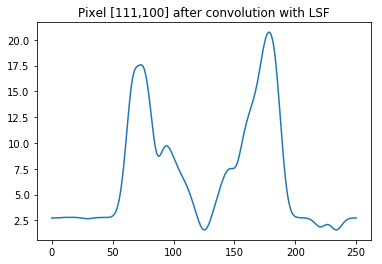

In [12]:
lms.convolve_lsf(plot=True)

# Scale the data cube to the detector pixel scale and spectral resolution:

In [13]:
lms.scale_to_detector()


ScaleToDetector: naxis = 201 201 67
image pixscale from WCS: [4.01736511 4.01736511] mas /pixel
Scale factor: [0.48992257 0.48992257]
99 99
ScaleToDetector: new shape = (67, 99, 99)


# Compute the output cube for a total integration time of 60 seconds:

Source peak: 1459346316390.3054 ph / (arcsec2 s um)
(67, 99, 99)
Wavelength grid: (67,)
Background max: 11892645.326646293 ph / (s um)
d_lambda 2.401661485426695e-05 um
Pixel area 6.724000000000001e-05 arcsec2
peak pos: (47, 49, 50)
Source peak: 2356.665068143262 ph / s
Background:  285.62108240846175 ph / s


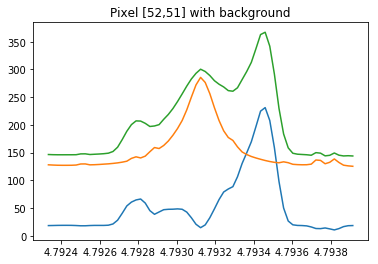

Peak 2492.5136078502146 ph / s , using DIT 32.09611363726907 s
Peak in one DIT 80000.0 ph
Total integration time 60.0 s => NDIT = 2.0


In [14]:
result = lms.compute_snr(60.*u.s)

In [15]:
cube = result.data
cube.shape

(67, 99, 99)

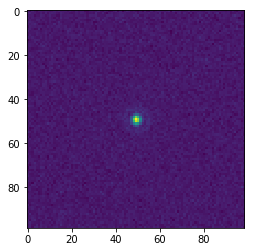

In [16]:
frame = cube[33,:,:]
plt.imshow(frame)